# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence, cmudict, sequence_to_text
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN
from utils import denormalize
import soundfile as sf

from pymo.writers import BVHWriter


/home/smehta/anaconda3/envs/gradtts/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import joblib as jl
from pathlib import Path
import warnings
from utils import generate_motion_visualization
motion_visualizer = jl.load("data/cormac/processed_sm0_0_86fps/data_pipe.expmap_86.1328125fps.sav")

/home/smehta/anaconda3/envs/gradtts/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
N_SPKS = 1  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)

In [5]:
# checkpoint_path = "logs/gradtts_rand_padFixedMirrorGPU3/grad_1024.pt"
checkpoint_path = "logs/diffuser/epoch_4000.pt"
# checkpoint_path = "logs/OnlySpeechGPU3/epoch_2500.pt"
# checkpoint_path = "logs/final_diffuser128GPU1/grad_3889.pt"

In [6]:
# params.n_motions = 45 
# params.window_size=4
# params.encoder_type="default"

In [7]:
checkpoint = torch.load(checkpoint_path, map_location=lambda loc, storage: loc)
params = checkpoint['params']
# params.encoder_type="default"
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.n_motions, params.dec_dim, params.beta_min, params.beta_max,
                    1000, params.mu_motion_encoder_params, params.decoder_motion_type, params.motion_reduction_factor,only_speech=False,
                    encoder_type=params.encoder_type)  # pe_scale=1 for `grad-tts-old.pt`
generator.load_state_dict(checkpoint['model'])
# params = checkpoint['params']
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')



Number of parameters: 91720396


In [8]:
cmu = cmudict.CMUDict('./resources/cmu_dictionary')

In [9]:
params.encoder_type

'default'

In [10]:
with open('checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

from hifigandenoiser import Denoiser

denoiser = Denoiser(hifigan, mode='zeros')

Removing weight norm...


In [11]:
texts = [
 "C4_2_eval_0137.wav|; you walk around Dublin city centre ; and even if you try and strike up a conversation with somebody it's impossible because everyone has their headphones in . ; And again , I would listen to podcasts sometimes ; with my headphones in walking around the streets .",
 "C3_5_eval_0005.wav|; Growing up, and ;, {IY2 V AH0 N} today;, I used to get in a lot of trouble. I used to mess quite a bit when I was younger because again I was like the class Clown and I like to impress people;, through messing, such.",
 "C3_7_eval_0506.wav|; and they {F IH1 N IH0 SH D}, {DH EY1 EH1}, they cleaned up the {W UW1 N D} and stuff; I stood up and I just {K AH0 L AE2 P S D} onto the ground and {F EY1 N T IH1 D}, because I was {K AH0 M P L IY1 T L IY1} drained, of all my {EH1 N ER0 JH IY1} of of everything like, it was absolutely! ;, oh so so bad.",
 "C4_2_eval_0245.wav|; But and again , so that doesn't help people like myself and my friend who ; actually want to strike up a conversation with a genuine person ; out in the open because , we don't want to go online , We don't feel like we have to do that .",
 "C4_1_eval_0251.wav|; I would like replenish stock; I would bring up stock for the off-license, that sort of stuff So I was doing all the kind of the menial kind of jobs, like the kind of boring; tedious work, that someone had to do.",
 "C3_7_eval_0060.wav|; I don't think anybody else did; Well I definitely didn't anyway because I was young. ; And, well obviously my parents hated, hated when we were getting out of bed because obviously we had school the next day and we had to get our sleep.",
 "C4_3_eval_0150.wav|; Yeah and then obviously there, there's certain choirs that come down to the church. ; There's a woman called. ; I can't remember her name. ; But she has an incredible voice. Like an amazing voice.",
 "C3_7_eval_0301.wav|; eventually got to a point where I was like okay I need to stop doing this sort of stuff Like it just doesn't make any sense as to why; Because I was getting hurt Like there was times where like; I was like tearing muscles and; I never broke a bone which I'm pretty proud of.",
 "C4_2_eval_0331.wav|; And because, of chatting to people online throughout the years; you do lose that ability to talk, and the ability to, just sporadically, chat to anybody.",
 "C3_7_eval_1074.wav|; when you think about it that ; , that you do as a child , it's just absolutely ridiculous that makes no sense; But you can always justify it back then because it just seemed like the fun right thing to do .",
 "C4_2_eval_0039.wav|; Because you can actually you actually do feel;, the {K AY2 N D} of the mental strains of {S OW2 SH AH1 L} {M IY1 D IY1 AH0} and; you know people depicting these perfect {L AY1 V Z} {AO1 N L AY2 AY2 N}, and you're like, {AO1 AO1 W W W}.",
 "C4_2_eval_0011.wav|; Just so this whole social networking stuff just really really ; annoys me and ;, cause it just warps people's minds and , people are so Fixated on their phones and that sort of stuff that I just hate that so much.",
 "C4_3_eval_0037.wav|;, {AE1 M} But yeah as I said before, so obviously I work in a bar, so, Christmas {IY2 V} in Hennessey is just {P AE1 K D} {JH AE1 M M D}, {IH2 N S EY1 EY1 N}. ; So myself and my brother will be working there this year.",
 "C3_7_eval_0047.wav|;, But I remember once my parents were; just downstairs in the kitchen. and this is when mobile phones just began coming out; so like my oldest brother and my oldest sister had a mobile phone each I'm pretty sure.",
 "C4_3_eval_0126.wav|; Like every, I think; most people even people who never go to mass ever. will go to mass on Christmas Eve or Christmas Day. ; So like what we used to do is we used to go to mass on Christmas Eve which was lovely, It's such a nice ceremony; because it's so like it's obviously 12 o'clock at night.",
 "C3_7_eval_0583.wav|; But ;, ;, moving on a few years, this is about maybe five six years {AH0 G OW1}, myself and my friends went to {P R AE1 G}; and then we came home and, they live in {W EH1 K S F ER1 D}.",
 "C3_7_eval_0876.wav|; But, but then I ended up in hospital for like three days; because they were doing loads of checks like {EH1 M} {AA1 R} {AY2 S} and all that sort of stuff on my head; because I kept on forgetting things and that sort of stuff and like.",
 "C4_2_eval_0521.wav|; trying to see if; if we can go back to the olden ways of just talking to people and actually engaging and communicating and seeing if; can relationships form, with just.",
 "C3_7_eval_0447.wav|; If you like touched it, it was, excruciatingly sore. ; And I went up to the teachers I was like look, I'm after like really damaging my {F IH0 NG G ER0}; I might have to go to the doctors.",
 "C4_2_eval_0059.wav|; Everything's, measured off of likes and all that sort of stuff and; how how people get valued these days, if someone has this amount of likes they're obviously deemed; great in society or looked upon as as perfect.",
 "C3_5_eval_0043.wav|; When I was in primary school I used to have this ruler ;, and I used to put it between desks, and I used to push the tables together; so the ruler would be between, the two tables.",
 "C3_7_eval_0163.wav|;, And then a few weeks {L EY1 T ER0} after that, my parents were away my granny was minding us ; and again I don't know why I told my brother to do this but I was like here.",
 "C4_3_eval_0092.wav|; I mean it, it's not that I'm against it, it's just that I just don't have the time and I just, sometimes I'm not bothered and that sort of stuff.",
 "C4_1_eval_0044.wav|; {K AY2 N D} of the best place to {F AY2 N D} {R IY1 L} {HH Y UW2 M AH0 N} {IY1 M OW2 SH AH0 N Z}; is in a pub; because you see it all. You literally see people who are, {AE1 NG G R IY0}, {S AE1 D};, {D EY0 Z D}, {HH AE1 P IY0}, {EH0 M} {D IH0 P R EH1 S D}.",
 "C3_7_eval_0732.wav|; But then it was annoying because I paid, because you have to pay the hospital fee of like a {HH AH1 N D R IH0 D} {K W IH1 D}; for for being seen and all the tests and stuff done; and then a receipt was sent to my house."

]

texts = [
     "C4_2_eval_0137.wav|; you walk around Dublin city centre ; and even if you try and strike up a conversation with somebody it's impossible because everyone has their headphones in . ; And again , I would listen to podcasts sometimes ; with my headphones in walking around the streets .",
     "C4_2_eval_0245.wav|; But and again , so that doesn't help people like myself and my friend who ; actually want to strike up a conversation with a genuine person ; out in the open because , we don't want to go online , We don't feel like we have to do that .",
     "C4_3_eval_0092.wav|; I mean it , it's not that I'm against it , it's just that I just don't have the time and I just , sometimes I'm not bothered and that sort of stuff .",

]



In [122]:





# text = "; So that was one of the games he used to do with us kind of creativity-wise; , and, Attention check, rate this audio a three, again, rate this audio a three."
filename = "attn_3"



attn_text = [
    "; and he was like yeah say you're sorry; So what we did was we; , We had all of our inter-railing tickets our money our phones everything;",
    "and we decided we'd get her a dog But; , The only thing is because I actually used to have a dog, My friends got me a dog; for my 20th birthday",
    "; So that was one of the games he used to do with us kind of creativity-wise; , and, And then he did another thing where he asked us to like…; do like improv shows or like do like.",
    "and there's basically obviously my two parents and then there's, Eight kids Well there's actually nine kids now; because my eldest sister had a niece and she's like we kind of, I pretty much count her as a little sister anyway."
]



sentences = {
    '1_neg' : "I went to a comedy show last night , and it was painfully unfunny . The jokes were outdated and offensive , and I couldn't wait for it to be over .",
    '1_pos' : "I went to a comedy show last night , and it was absolutely hilarious . The jokes were fresh and clever , and I laughed so hard my sides hurt .",
    '2_neg' : "I tried to plan a surprise birthday party for my partner , but everything went wrong . The cake was ruined , the guests arrived late , and ; and my partner figured it out beforehand .",
    '2_pos' : "I planned a surprise birthday party for my partner , and everything went perfectly . The cake was delicious , the guests arrived on time , and ; and my partner was genuinely surprised ."
}


filename = '2_neg'
text = sentences[filename]

# filename, text = texts[2].split('|')
# filename = Path(filename).stem

# text = "and the train stopped ; The door opened; I got out first; Then Jack Kane got out, Ronan got out, Louise got out."

# # text = " Jim asked if we should do a group hug , it was a strange request , but then ; he insisted again , this time I had to shout ; No, please not again , no , never, I dont want to hug ,; please leave me alone and I went out, ."
# text = " I started counting one ; two ; three and then I turned back I see ; everyone ran and hid somewhere , the game of hide and seek was so fun ,; I am going to play it again later , with my niece and nephew ."
# # text = "; So , I went to the other side ; and then suddenly I saw someone running towards me , I didn't really understand who it was but then I heard the noise and I was like no , screw this , ; I just started running and I ran as fast as I possibly could ."
# filename = "mayank"
# text = "Hello , Divya and Mayank , Congratulation on the being future mother and father , my AI voice wishes you a fun happy time ahead . ;"
# text = "drop the car off in Miami ; , and that was fine So we had a big plan ; And so literally one morning one by one ; We would literally run down the stairs with our bags and then just we just ran ."


filename, text = texts[0].split('|')

# text = "Thank you , really Thank you everyone ; It turned out to be such a nice and fun paper . I really like it ! "


text =  "Presenting , our latest work , Diff T T S G , ; ,; that can synthesize both speech and gestures together in one system trained end to end with only text as input ."
# text =  ", ,; Scan the Q R code or , visit the link for more information on Diff T T S G ."
# text = "When we have the power to synthesize natural sounding speech , ; ,; why should we limit ourselves to , just speech ."
 


In [123]:
text, filename

('Presenting , our latest work , Diff T T S G , ; ,; that can synthesize both speech and gestures together in one system trained end to end with only text as input .',
 'C4_2_eval_0137.wav')

In [124]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 303]), tensor([303], device='cuda:0'))

In [125]:
sequence_to_text(x.squeeze(0).tolist())

'{P R IH0 Z EH1 N T IH0 NG} , {AW1 ER0} {L EY1 T AH0 S T} {W ER1 K} , {D IH1 F} {T IY1} {T IY1} {EH1 S} {JH IY1} , ; ,; {DH AE1 T} {K AE1 N} {S IH1 N TH AH0 S AY2 Z} {B OW1 TH} {S P IY1 CH} {AH0 N D} {JH EH1 S CH ER0 Z} {T AH0 G EH1 DH ER0} {IH0 N} {W AH1 N} {S IH1 S T AH0 M} {T R EY1 N D} {EH1 N D} {T UW1} {EH1 N D} {W IH1 DH} {OW1 N L IY0} {T EH1 K S T} {AE1 Z} {IH1 N P UH2 T} .'

Grad-TTS RTF: 0.9048235338673857


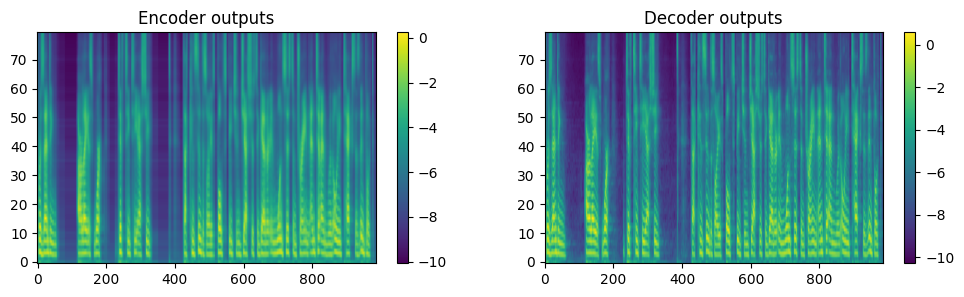

In [126]:
n_timesteps = {
    'mel': 50,
    'motion': 500,
}

length_scale=1.15

temperature = {
    'mel': 1.3,
    'motion': 1.5
}

t = dt.datetime.now()
generator.motion_reduction_factor = 1
y_enc, y_dec, y_motion_enc, y_motion_dec, attn = generator.forward(x, x_lengths, n_timesteps=n_timesteps, temperature=temperature,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=length_scale)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')
# Denormalize
y_dec = denormalize(y_dec, params.data_parameters['mel_mean'], params.data_parameters['mel_std'])
y_enc = denormalize(y_enc, params.data_parameters['mel_mean'], params.data_parameters['mel_std'])
# motion_output = denormalize(y_motion_dec[:, 3:], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])
if y_motion_dec is not None:
    motion_output = denormalize(y_motion_dec[:, :], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])


plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()

In [127]:
# motion_output = denormalize(y_motion_enc[:, :], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])
motion_output = denormalize(y_motion_dec[:, :], params.data_parameters['motion_mean'], params.data_parameters['motion_std'])



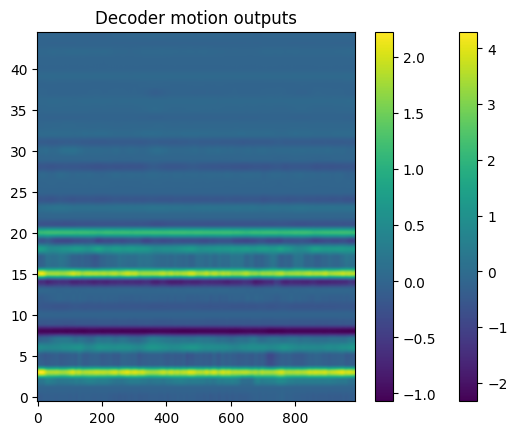

In [128]:
if y_motion_dec is not None:
    plt.title('Encoder motion outputs')
    plt.imshow(y_motion_enc.cpu().squeeze(), aspect='auto', origin='lower')
    plt.colorbar()
    plt.title('Decoder motion outputs')
    plt.imshow(motion_output.cpu().squeeze(), aspect='auto', origin='lower')
    plt.colorbar()

In [129]:
# Hifigan input b, c, T
with torch.no_grad():
#     audio = hifigan.forward(y_enc[:, :]).clamp(-1, 1)
    audio = hifigan.forward(y_dec[:, :]).clamp(-1, 1)
    audio = denoiser(audio.squeeze(0), 0.0005).cpu().squeeze()
ipd.display(ipd.Audio(audio, rate=22050))

In [130]:
# import torch.nn.functional as F

# motion_output = F.interpolate(motion_output[:, :, ::4], motion_output.shape[-1], mode='linear')
# # # motion_output = F.interpolate(motion_output[:, :, ::4], motion_output.shape[-1])
# # motion_output = motion_output[:, :, ::4]

In [131]:
output_folder = Path('syn_motion_output')
output_folder.mkdir(exist_ok=True, parents=True)
np.save(output_folder / filename, y_dec.cpu().numpy())
sf.write((output_folder / filename).with_suffix('.wav'), audio, 22050, 'PCM_24')

if y_motion_dec is not None:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        i = filename
        # 86
#         generate_motion_visualization(audio.cpu(), output_folder/f'{i}.wav', motion_output.cpu().squeeze(0).T, output_folder/f'{i}.mp4', motion_visualizer, output_folder/f'{i}.bvh')    
        # 20 fps
    #     generate_motion_visualization(audio.cpu(), output_folder/f'{i}.wav', motion_output.cpu().squeeze(0).T, output_folder/f'{i}.mp4', motion_visualizer20fps, output_folder/f'{i}.bvh')    
    
        audio = audio.cpu()
        audio_filename = output_folder/f'{i}.wav'
        motion = motion_output.cpu().squeeze(0).T
        motion_filename = output_folder/f'{i}.mp4'
        motion_visualizer_pipeline = motion_visualizer
        output_folder/f'{i}.bvh'
        audio_filename = Path(audio_filename)
        bvh_filename = output_folder/f'{i}.bvh'

        sf.write(audio_filename, audio.flatten(), 22500, "PCM_24")

        # Add motion target
        bvh_values = motion_visualizer_pipeline.inverse_transform([motion])

        if bvh_filename is not None:
            # Write input bvh file
            writer = BVHWriter()
            with open(bvh_filename, "w") as f:
                writer.write(bvh_values[0], f)

In [223]:
# motion_visualizer20fps = jl.load("data/cormac/processed_sm0_0_20fps/data_pipe.expmap_20fps.sav")

In [224]:
output_folder = Path('syn_motion_output')
output_folder.mkdir(exist_ok=True, parents=True)
np.save(output_folder / filename, y_dec.cpu().numpy())
sf.write((output_folder / filename).with_suffix('.wav'), audio, 22050, 'PCM_24')

if y_motion_dec is not None:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        i = filename
        # 86
        generate_motion_visualization(audio.cpu(), output_folder/f'{i}.wav', motion_output.cpu().squeeze(0).T, output_folder/f'{i}.mp4', motion_visualizer, output_folder/f'{i}.bvh')    
        # 20 fps
    #     generate_motion_visualization(audio.cpu(), output_folder/f'{i}.wav', motion_output.cpu().squeeze(0).T, output_folder/f'{i}.mp4', motion_visualizer20fps, output_folder/f'{i}.bvh')    



MocapParameterizer: position


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [225]:
output_folder/filename

PosixPath('syn_motion_output/C4_2_eval_0137.wav')

In [226]:
from IPython.display import Video


Video((output_folder/filename).with_suffix('.wav.mp4'), embed=True)